In [2]:
import os
import polars as pl

if os.path.isfile("data/hn.parquet"):
    print("Loading from cache")
    hn = pl.read_parquet("data/hn.parquet")
else:
    from datasets import load_dataset

    hn: pl.DataFrame = pl.from_pandas(
        load_dataset("OpenPipe/hacker-news")["train"].to_pandas()
    )
    hn.write_parquet("data/hn.parquet")

hn.shape

Loading from cache


(38109500, 14)

In [10]:
from datetime import datetime

stories = hn.filter(
    (pl.col("type") == "story")
    & (pl.col("text").is_null())
    & (pl.col("url").is_not_null())
    & (pl.col("score") >= 30)
    & (pl.col("descendants") >= 5)
    & (pl.col("time") >= datetime(2010, 1, 1))
)

print(f"Number of stories: {stories.height}")
display(stories.sort("time").tail(5))

Number of stories: 285603


id,type,by,time,title,text,url,score,parent,top_level_parent,descendants,kids,deleted,dead
i64,str,str,datetime[μs],str,str,str,f64,f64,i64,f64,list[i64],bool,bool
38107297,"""story""","""kristianpaul""",2023-11-02 00:26:02,"""NASA+: Our New…",null,"""https://www.na…",53.0,null,38107297,11.0,"[38109407, 38109358, … 38108262]",null,null
38107413,"""story""","""bexsella""",2023-11-02 00:39:42,"""High-level emu…",null,"""https://github…",66.0,null,38107413,28.0,"[38107957, 38108038, … 38108658]",null,null
38107537,"""story""","""lxm""",2023-11-02 00:55:32,"""As child care …",null,"""https://www.cb…",80.0,null,38107537,145.0,"[38108043, 38108132, … 38108475]",null,null
38107711,"""story""","""lagniappe""",2023-11-02 01:16:22,"""Window-swap – …",null,"""https://www.wi…",74.0,null,38107711,22.0,"[38108389, 38108527, … 38108699]",null,null
38108873,"""story""","""g42gregory""",2023-11-02 04:05:21,"""Yann LeCun: AI…",null,"""https://www.bu…",59.0,null,38108873,28.0,"[38109384, 38109151, … 38109307]",null,null


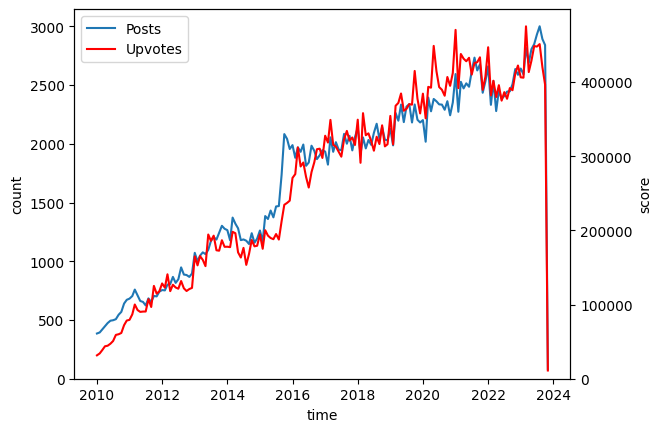

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = (
    stories.sort(by="time")
    .group_by_dynamic("time", every="1mo", period="1mo")
    .agg(
        [
            pl.count(),
            pl.sum("score"),
        ]
    )
)

ax1 = sns.lineplot(data=scores, x="time", y="count", label="Posts")

ax2 = ax1.twinx()

sns.lineplot(data=scores, x="time", y="score", ax=ax2, color="r", label="Upvotes")

ax1.set_ylim(0, None)
ax2.set_ylim(0, None)

# Handle lines and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine them
ax1.legend().remove()
ax2.legend(lines + lines2, labels + labels2, loc=0)

# increase dpi when displaying in jupyter
plt.rcParams["figure.dpi"] = 300

plt.show()

In [11]:
id_to_text = hn[["id", "text"]].to_pandas().set_index("id", drop=True)

stories = stories.with_columns(
    pl.col("kids")
    .map_elements(
        lambda kids: None if kids.is_empty() else id_to_text.iloc[kids[0]]["text"]
    )
    .alias("top_comment")
)

stories.shape

(285603, 15)

In [12]:
stories.write_parquet("data/stories.parquet")

In [5]:
training_stories = stories.sample(3000, seed=42)

training_stories.head(5)

id,type,by,time,title,text,url,score,parent,top_level_parent,descendants,kids,deleted,dead,top_comment
i64,str,str,datetime[μs],str,str,str,f64,f64,i64,f64,list[i64],bool,bool,str
11369756,"""story""","""based2""",2016-03-27 12:30:43,"""Dimple: An obj…",null,"""http://dimplej…",150.0,null,11369756,31.0,"[11372346, 11372145, … 11374740]",null,null,"""<a href=""https…"
15392159,"""story""","""pritambarhate""",2017-10-03 13:17:38,"""Matcha – A fra…",null,"""https://github…",320.0,null,15392159,125.0,"[15392855, 15393525, … 15392780]",null,null,"""I think it&#x2…"
15147497,"""story""","""AlexeyBrin""",2017-09-01 11:21:56,"""Linux desktop …",null,"""https://www.ne…",146.0,null,15147497,157.0,"[15148786, 15148659, … 15150049]",null,null,"""Been running L…"
28218892,"""story""","""gamontserrat""",2021-08-18 08:39:24,"""Environmental …",null,"""https://home.c…",41.0,null,28218892,6.0,"[28219635, 28219619]",null,null,"""I miss the sol…"
21961416,"""story""","""Decabytes""",2020-01-05 14:44:26,"""Torvalds' Comm…",null,"""https://www.ph…",34.0,null,21961416,8.0,"[21962017, 21962153, … 21962130]",null,null,"""Active discuss…"


In [ ]:
from joblib import Memory, Parallel, delayed
import openpipe
import os
from dotenv import load_dotenv
import json

load_dotenv()

openpipe.configure_openpipe(api_key=os.getenv("OPENPIPE_API_KEY"))

openpipe.openai.api_key = os.getenv("OPENAI_API_KEY")

memory = Memory("/workspace/cache", verbose=0)


@memory.cache
def classify_story(row):
    resp = openpipe.openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {
                "role": "system",
                "content": "Determine whether the HN story is likely related to any of the given subjects. Multiple subjects may apply.",
            },
            {
                "role": "user",
                "content": f"Headline: {row['title']}\nURL: {row['url']}\nTop comment: {row['top_comment']}",
            },
        ],
        functions=[
            {
                "name": "classify",
                "description": "Important: only return true for a label if the story is likely related to the subject. If it isn't related, or if you aren't sure, return false.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "ai_ml": {
                            "type": "boolean",
                            "description": "Related to AI, ML, AGI, etc.",
                        },
                        "crypto": {
                            "type": "boolean",
                            "description": "Related to crypto, blockchain, etc.",
                        },
                        "remote_work": {
                            "type": "boolean",
                            "description": "Related to remote work, WFH, etc.",
                        },
                        "rust": {
                            "type": "boolean",
                            "description": "Related to the Rust language.",
                        },
                    },
                    "required": ["ai_ml", "crypto", "remote_work", "rust"],
                },
            }
        ],
        openpipe={"tags": {"prompt_id": "classify_hn_story_v4"}},
        function_call={"name": "classify"},
    )
    json.loads(resp.choices[0].message.function_call.arguments)
    return resp


classify_story(training_stories[2].to_dicts()[0])

<OpenAIObject chat.completion id=chatcmpl-8GVUWw34KnXCbP02rpghPdEIu3UPa at 0x7f411659fc90> JSON: {
  "id": "chatcmpl-8GVUWw34KnXCbP02rpghPdEIu3UPa",
  "object": "chat.completion",
  "created": 1698944992,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "classify",
          "arguments": "{\n\"ai_ml\": false,\n\"crypto\": false,\n\"remote_work\": false,\n\"rust\": false\n}"
        }
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 465,
    "completion_tokens": 23,
    "total_tokens": 488
  },
  "openpipe": {
    "cache_status": "SKIP"
  }
}

In [ ]:
from joblib import Parallel, delayed
import tqdm


def process_input(row):
    try:
        output = classify_story(row)
    except Exception as e:
        print(e)
    row["tags"] = json.loads(output.choices[0].message["function_call"]["arguments"])

    row["prompt_tokens"] = output.usage.prompt_tokens
    row["completion_tokens"] = output.usage.completion_tokens
    return row


# Parallelize using joblib
results = Parallel(n_jobs=30)(
    delayed(process_input)(row) for row in tqdm.tqdm(training_stories.rows(named=True))
)

results = pl.DataFrame(results).unnest("tags")

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:00<15:07,  3.31it/s]Exception ignored in: <function _releaseLock at 0x7f42521681f0>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
  2%|▏         | 60/3000 [00:09<06:25,  7.63it/s]

In [ ]:
results["rust"].value_counts()

rust,counts
bool,u32
false,588
true,12


In [ ]:
import openpipe
from dotenv import load_dotenv
import os

load_dotenv()

# openpipe.configure_openpipe(
#     api_key=os.getenv("OPENPIPE_API_KEY"), base_url="http://localhost:3000/api/v1"
# )
openpipe.configure_openpipe(api_key=os.getenv("OPENPIPE_API_KEY"))

await openpipe.openai.ChatCompletion.acreate(
    model="openpipe:classify-hn-stories",
    messages=[
        {
            "role": "system",
            "content": "This is an HN headline and top comment. Your job is to determine whether the story is likely related to any of the given subjects. Multiple subjects may apply.",
        },
        {
            "role": "user",
            "content": "Headline: A new Rust compiler is released\nURL: https://rust-lang.org\nTop comment: This is a top comment about Rust.",
        },
    ],
    function_call={"name": "classify"},
)

{
  "id": "adcc61d4-4d91-41c0-9885-f2bc9f60d382",
  "object": "chat.completion",
  "created": 1697603891961,
  "model": "openpipe:classify-hn-headlines",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "classify",
          "arguments": "{\n\"rust\": true\n}"
        }
      }
    }
  ],
  "usage": {
    "prompt_tokens": 110,
    "completion_tokens": 16,
    "total_tokens": 126
  }
}


<OpenAIObject chat.completion id=adcc61d4-4d91-41c0-9885-f2bc9f60d382 at 0x7f51ef189ee0> JSON: {
  "id": "adcc61d4-4d91-41c0-9885-f2bc9f60d382",
  "object": "chat.completion",
  "created": 1697603891961,
  "model": "openpipe:classify-hn-headlines",
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "classify",
          "arguments": "{\n\"rust\": true\n}"
        }
      }
    }
  ],
  "usage": {
    "prompt_tokens": 110,
    "completion_tokens": 16,
    "total_tokens": 126
  },
  "openpipe": {
    "cache_status": "SKIP"
  }
}

In [ ]:
import os
from dotenv import load_dotenv
import json

load_dotenv()

# configure_openpipe(api_key=os.getenv("OPENPIPE_API_KEY"))

# openai.api_key = os.getenv("OPENAI_API_KEY")


# @memory.cache
def classify_story_with_mistral(row):
    resp = openpipe.openai.ChatCompletion.create(
        model="openpipe:classify-hn-headlines",
        messages=[
            {
                "role": "system",
                "content": "This is an HN headline and top comment. Your job is to determine whether the story is likely related to any of the given subjects. Multiple subjects may apply.",
            },
            {
                "role": "user",
                "content": f"Headline: {row['title']}\nURL: {row['url']}\nTop comment: {row['top_comment']}",
            },
        ],
        functions=[
            {
                "name": "classify",
                "description": "Important: only return true for a label if the story is likely related to the subject. If it isn't related, or if you aren't sure, return false.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "ai_ml": {
                            "type": "boolean",
                            "description": "Related to AI, ML, AGI, etc.",
                        },
                        "crypto": {
                            "type": "boolean",
                            "description": "Related to crypto, blockchain, etc.",
                        },
                        "remote_work": {
                            "type": "boolean",
                            "description": "Related to remote work, WFH, etc.",
                        },
                        "rust": {
                            "type": "boolean",
                            "description": "Related to the Rust language.",
                        },
                    },
                    "requred": ["ai_ml", "crypto", "remote_work", "rust"],
                },
            }
        ],
        function_call={"name": "classify"},
    )
    json.loads(resp.choices[0].message.function_call.arguments)
    return resp


classify_story_with_mistral(training_stories[0].to_dicts()[0])

NameError: name 'training_stories' is not defined